In [1]:
#Makes sure that the plots are rendered/showed when run
%matplotlib inline

In [2]:
import os

import mne
import numpy as np


# Preprocessing
The steps in EEG preprocessing:

* Highpass filter
* Lowpass filter
* Artefact rejection
    * Ocular artifacts (EOG)
    * Heartbeat artifacts (ECG)
    * Power line noise
    * Methods:
        * Thresholding
        * ICA
* (Rereference)
* Epoching
* Evokeds (i.e. averaging)


In [3]:
#Getting the data (creating the folder if not already found/downloaded)
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')

In [4]:
#Putting data into "raw" variable
#Preload = T loads the data into memory, so that we can filter it
#(before this, it is just loading all the information about the channels and stuff)
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)

Opening raw data file C:\Users\louis\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


In [5]:
#Types of data (MEG? EEG? STIMULI?)
raw.pick_types(meg=False, eeg=True, stim=True)

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


<Raw | sample_audvis_filt-0-40_raw.fif, 68 x 41700 (277.7 s), ~24.6 MB, data loaded>

In [6]:
#Checking whether the data is already filtered (essentially repeating what is being done above)
raw.info
#Showing that it is filtred with 0.1 (lowpass) and 40 (highpass)
# = When loaded data is filtered at 0.1 and 40 hZ

<Info | 14 non-empty values
 bads: []
 ch_names: STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, STI 014, ...
 chs: 9 STIM, 59 EEG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 68
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>

In [7]:
# filter your data
# In this case that data is already filtered at 0.1 and 40hz

#The filters are reversed - l_freq = highpass, and h_freq = lowpass
#creating a copy in order to still have the basic "raw" unchanged
raw_filtered = raw.copy().filter(l_freq=None, h_freq=40) #this is redundant in this case
raw_filtered = raw.copy().filter(l_freq=0.1, h_freq=None) #this is redundant in this case

#High pass filter first, then low pass filter (instead of both at the same time, which can produce more artifacts)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 51 samples (0.340 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 4957 samples (33.013 sec)



Default filtering for the sample data is:
* highpass: 0.1 Hz
* lowpass: 40 Hz

You can see this by:
print(raw.info)

In [15]:
# set up and fit the ICA
#Takes raw time series, splits into n_components (normally you could say give me as many components
# until it explain 95% of the varaiance, instead of giving it a specific number - maybe you need pca for this) - used to detect noise.
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
#ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800) #trying the variance thing (no pca?)
ica.fit(raw)

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.6s.


<ICA | raw data decomposition, fit (fastica): 41700 samples, 20 components, channels used: "eeg">

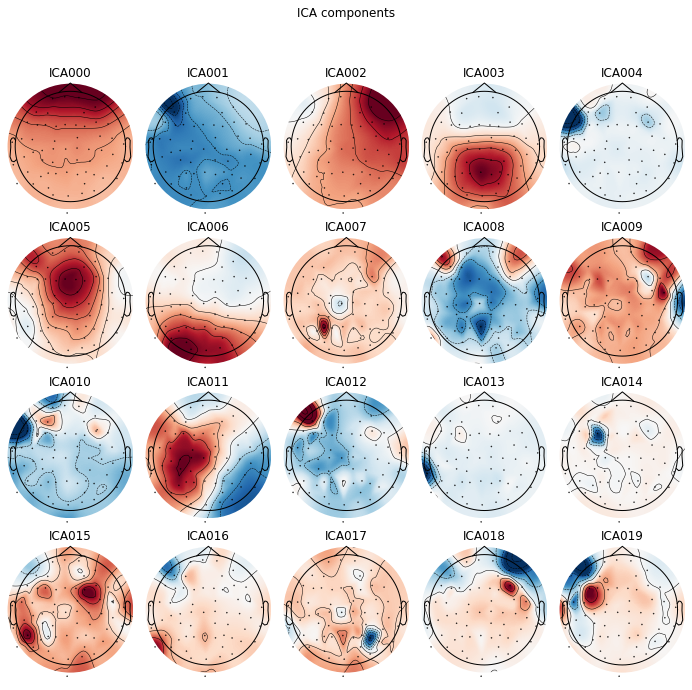

In [16]:
#visualising components
ica.plot_components(); #can be used to look at the components. They are plotted by variance that
#they explain (the first explains most of the variance) (often the eyeblinks would be in the top)

# Also, these components are accumulated across time and channels - grouping components, that look alike.
# Thus, several channels at several time points can potentially be combined into one component

Creating RawArray with float64 data, n_channels=20, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


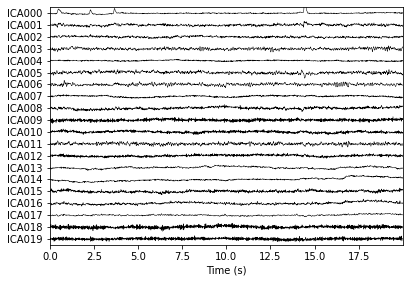

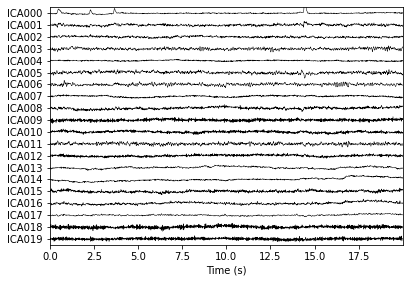

In [17]:
#Plotting the time series of the ICA (plotting the components - also to detect artifacts)
ica.plot_sources(raw, show_scrollbars=False)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


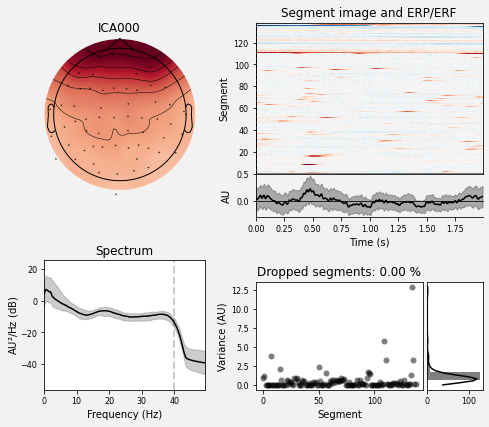

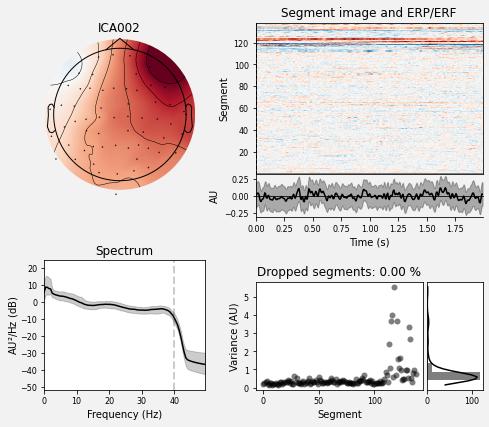

In [18]:
#Excluding the artifacts
ica.exclude = [0, 2]  #These are two of the components, which we want to leave out/exclude. He knows these are eyeblinks/artifacts
# (details on how we picked these are omitted here)
# 0 = eyeblink, 2 = saccade
ica.plot_properties(raw, picks=ica.exclude); #examining these two excluded artifacts

In [19]:
orig_raw = raw.copy() #making a copy first, since it changes the data to apply the ica
raw.load_data() #might not be needed as we did preload = True earlier

#Applying the ICA (ow that the exclusions have been set, we can reconstruct the sensor signals
# with artifacts removed using the apply method)
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components


<Raw | sample_audvis_filt-0-40_raw.fif, 68 x 41700 (277.7 s), ~24.6 MB, data loaded>

There are many options with ICA, see
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
for a tutorial on ICA in MNE-python.

In [23]:
# the stimulus channel on the Electra vector view is: STI 014
# The channel names can be found by
print(raw.info)
events = mne.find_events(raw, stim_channel='STI 014')

<Info | 14 non-empty values
 bads: []
 ch_names: STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, STI 014, ...
 chs: 9 STIM, 59 EEG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 68
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>
319 events found
Event IDs: [ 1  2  3  4  5 32]


In [26]:
print(events[:5])  # show the first 5 events

#sample number in the first column and integer event ID in the last column;
#the middle column is usually ignored

[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [36]:
#Rather than keeping track of integer event IDs, we can provide an event dictionary that
#maps the integer IDs to experimental conditions or events. In this dataset, the mapping looks like this
event_dict = {'auditory/left': 1,
              'auditory/right': 2,
              'visual/left': 3,
              'visual/right': 4,
              }

#Alternatively, this is what the website says
#https://mne.tools/stable/auto_tutorials/intro/10_overview.html?fbclid=IwAR3kFG-8lOTQkKIx6k0jFMz9jB_uwSVdjul4IpsEj95TqNmKw9UQrhbCjpI
#event_dict = {'auditory/left': 1,'auditory/right': 2, 'visual/left': 3,
#              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

event_dict

{'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3, 'visual/right': 4}

In [ ]:
#Event dictionaries like this one are used when extracting epochs from continuous data;
# the / character in the dictionary keys allows pooling across conditions by requesting partial
# condition descriptors (i.e., requesting 'auditory' will select all epochs with Event IDs 1 and 2;
# requesting 'left' will select all epochs with Event IDs 1 and 3).

<ipython-input-29-1ec2ff663b96>:3: RuntimeWarning: event 5 missing from event_id will be ignored
  first_samp=raw.first_samp)
<ipython-input-29-1ec2ff663b96>:3: RuntimeWarning: event 32 missing from event_id will be ignored
  first_samp=raw.first_samp)


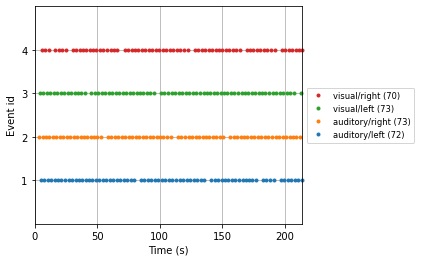

In [29]:
#Trying to plot the events
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

In [30]:
# Rejection parameters based on peak-to-peak amplitude
reject = dict(eeg=150e-6)  # 150 µV

#data quality constraints: we’ll reject any epoch where peak-to-peak signal amplitude is
#beyond reasonable limits for that channel type. This is done with a rejection dictionary;
#you may include or omit thresholds for any of the channel types present in your data

In [31]:
#the conditions we care about (don't know what we use it for)
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']


In [38]:
# (Two) EOG channels are used to monitor both horizontal and vertical eye movements
# Specifying that we want to include EEG and EOG channels in the epochs below
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True)


# by default Raw and Epochs data aren’t loaded into memory (they’re accessed
# from disk only when needed), but here we’ll force loading into memory using the preload=True 
# parameter so that we can see the results of the rejection criteria being applied:
epochs = mne.Epochs(raw, events, event_dict, -.2, 0.5, picks=picks,
                    baseline=None, reject=reject, preload=True)
# In the above:
# We’ll pass the event dictionary as the event_id parameter (event_id = event_dict) so we can work with
# easy-to-pool event labels instead of the integer event IDs.
# We specify tmin = -0.2 and tmax = 0.5 (the time relative to each event at which to start and end each epoch).
# And put in the reject parameters based on peak-to-peak amplitude (defined above)

epochs

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 288 events and 106 original time points ...
0 bad epochs dropped


Number of events,288
Events,auditory/left: 72auditory/right: 73visual/left: 73visual/right: 70
Time range,-0.200 – 0.499 sec
Baseline,off


In [40]:
#Equalize the number of trials in each conditions (as seen above, there are 72, 73, 73, 70)
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
# Now all of the conditions have 70 trials

Dropped 8 epochs: 0, 1, 14, 15, 16, 33, 91, 210


(<Epochs |  280 events (all good), -0.199795 - 0.499488 sec, baseline off, ~16.3 MB, data loaded,
  'auditory/left': 70
  'auditory/right': 70
  'visual/left': 70
  'visual/right': 70>,
 array([ 14,  33,   0,  15,  91,   1,  16, 210], dtype=int64))

# Comparing evokeds

To visually comparing different evoked objects it is a good idea to calculate
 a _difference  wave_, i.e. one condition minus the other condition. In
 MNE-python ```mne.combine_evokeds```can do that.

In [43]:
# Gathering all auditory conditions (left + right) and visual conditions (left + right)
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']
#del raw, epochs  # free up memory

aud_epochs #140 auditory events and thus epochs (same for visual)

Number of events,140
Events,visual/left: 70visual/right: 70
Time range,-0.200 – 0.499 sec
Baseline,off


Not setting metadata
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


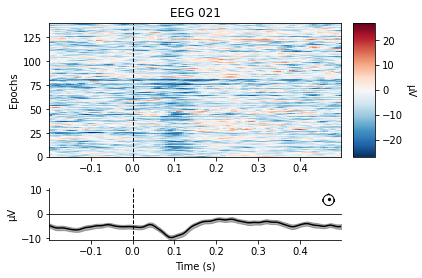

[<Figure size 432x288 with 4 Axes>]

In [44]:
# Plotting using plot_image, which shows each epoch as one row of an image map,
# with color representing signal magnitude; the average evoked response and the sensor
# location are shown below the image:
aud_epochs.plot_image(picks=['EEG 021'])

Now that we have our conditions in aud_epochs and vis_epochs, we can get an estimate of evoked responses to auditory versus visual stimuli by averaging together the epochs in each condition.

In [45]:
#Averaging the epochs in each condition (auditory vs. visual) to get an estimate of evoked responses
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

combining channels using "gfp"
combining channels using "gfp"


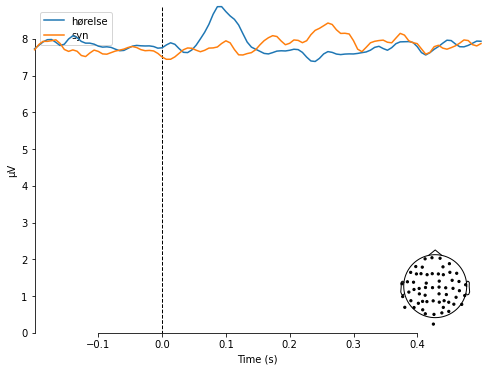

[<Figure size 576x432 with 2 Axes>]

In [58]:
# using a function from the mne.viz module to compare the global field power for each sensor
# type of the two Evoked object

#In the dict in the evokeds= we define which word to associate with the evoked variable to be shown on the plot
mne.viz.plot_compare_evokeds(evokeds=dict(hørelse=aud_evoked, syn=vis_evoked),
                             legend='upper left', show_sensors='lower right')

Projections have already been applied. Setting proj attribute to True.


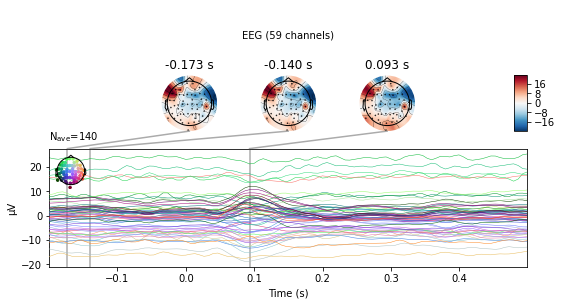

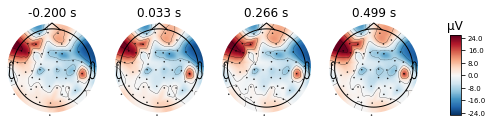

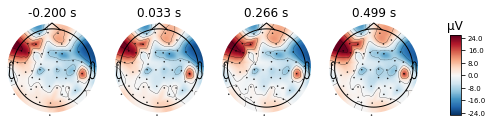

In [66]:
# Getting a more detailed view of the evoked object for auditory conditions using plot_joint and the other
aud_evoked.plot_joint(picks=('eeg'))
#vis_evoked.plot_joint(picks='eeg')
aud_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg') #some relevant and some arbitrary times

Projections have already been applied. Setting proj attribute to True.


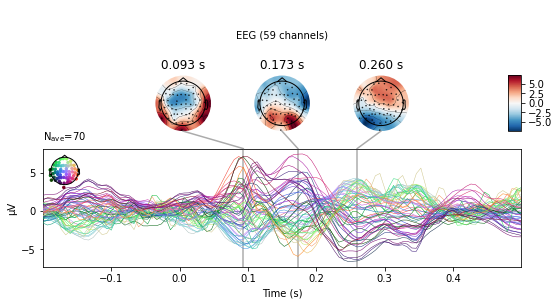

combining channels using "gfp"


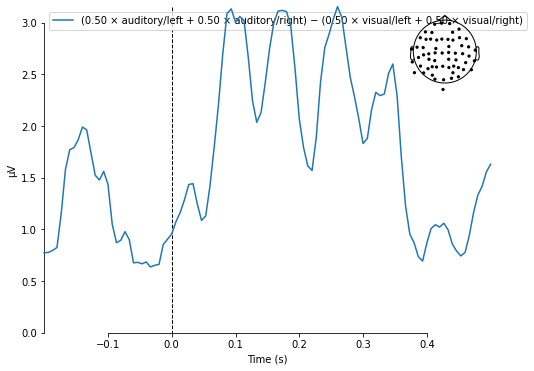

[<Figure size 576x432 with 2 Axes>]

In [78]:
#To visually comparing different evoked objects it is a good idea to calculate 
# a _difference  wave_, i.e. one condition minus the other condition. In MNE-python
# mne.combine_evokeds can do that.


# Change to your evokeds

difference_wave = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
difference_wave.plot_joint()

# The one-line graph of the difference wave
mne.viz.plot_compare_evokeds(evokeds=difference_wave,
                             legend='upper left', show_sensors='upper right')

See also:
https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html